<h2 style="color:crimson">Tarea 7 - Joaquín Trejo</h2>

**Utilizando la base "train.csv", genera un modelo que mejore la R2 y el MAE que se obtuvo en la Tarea 2 de este módulo**

Como primer paso, debemos extraer la información con la que trabajaremos, por lo que es necesario que el archivo `"train.csv"` se encuentre en la misma carpeta en donde se encuentra este notebook. Esto lo realizaremos mediante la extracción de un archivo y trasladándolo a un `PandasDataFrame`:

In [458]:
import pandas as pd
housing = pd.read_csv("train.csv")
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Vamos a revisar el tipo de información que contiene nuestra base.

In [459]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Existen columnas como **"Alley", "PoolQC", "Fence", "FireplaceQu"y "MiscFeature"** que tienen menos de la mitad del total de regitros (1460) registros, por lo que no serán contempladas en el modelo. 

**De igual forma existen muchas columnas del tipo object**, las cuales contienen variables del tipo categòricas a las cuales se les debe aplicar una transformación para que puedan ser consideradas dentro del modelo.

In [460]:
housing[["Alley", "PoolQC", "Fence", "FireplaceQu","MiscFeature"]].head()

,Alley,PoolQC,Fence,FireplaceQu,MiscFeature
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,TA,NaN
2,NaN,NaN,NaN,TA,NaN
3,NaN,NaN,NaN,Gd,NaN
4,NaN,NaN,NaN,TA,NaN


Vamos a guardar en una lista, todas las variables categóricas de la base de datos.

In [461]:
variables_categoricas = list(housing.select_dtypes(include='object').columns.values)

for i in ["Alley", "PoolQC", "Fence", "FireplaceQu","MiscFeature"]:
    variables_categoricas.remove(i)

variables_categoricas

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

**Como vimos anteriormente, existen muchos datos del tipo "NaN", loc suales hay que sustituir en la base mediante**  `backfill`, **utilizando el método** `pd.fillna`.

In [462]:
housing = housing.fillna(method="backfill")

**Ahora bien, como primer paso debemos generar los sets de entrenamiento y evaluación, para lo cual debemos importar la librería correspondiente y eliminar de los sets de entrenamiento la variable que deseamos estimar**

In [593]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(housing, test_size=0.2, random_state=2718)
xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]
xtest, ytest =test.drop("SalePrice", axis=1), test["SalePrice"]

Como bien se mencionó anteriormente, existen variables que son  tipo `object`, las cuales deben ser tranformadas a valores numéricos.

Esto se puede realizar mediante la aplicación de un `OneHotEncode`; sin embargo, se tiene un problema, el cual consuste en que si dentro del `train set`existe alguna categoría (valor categorico) que no existe en el `test set`, obtendremos un error.

Por lo cual debemos incluir dentro del paramtero `categories`una array que contenga todas las categorìas de cada columna, de tal forma que:

$$ Categorias[0]\;contiene\;el\;listado\;de\;categorías\;correspondientes\;a\;la\;columna\;0$$

Por lo que debemos generar ese listado:

In [450]:
categorias = []

for j in variables_categoricas:
    categorias.append(list(housing[j].unique()))

Como ejemeplo, se ilustra el listado de categorìas para las columnas 1,2 y 3:

**categorias[0:3] =  `[  ['RL', 'RM', 'C (all)', 'FV', 'RH'],   ['Pave', 'Grvl'],  ['Reg', 'IR1', 'IR2', 'IR3']  `'**

En este momento poemos generar un primer modelo en el cual, consideraremos todas las variables que existen en el listado. Para ello debemos importar las siguientes librerìas que nos serviràn para cada uno de los modelos a generar.

In [454]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate,GridSearchCV, cross_val_score

<h2 style="color:Darkblue">Primer modelo: Random Forest Regressor <h2>
 
**Utilizando Grid Search para encontrar los parámetros óptimos**

In [202]:
column_selector_primer_modelo = ColumnTransformer(
    [("Encoder", OneHotEncoder(categories = categorias,sparse=False), variables_categoricas),
     ("Imputer", SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), make_column_selector(dtype_include=["float","integer"])),
     ("Scaler", StandardScaler(),make_column_selector(dtype_include=["integer"])), 
     ("Normalizer",Normalizer(),make_column_selector(dtype_include=["integer"]))
    ]
)
    
pipeline_primer_modelo = Pipeline([ 
    ("select_cols", column_selector_primer_modelo), 
    ("random_forest",  RandomForestRegressor(max_depth=None, criterion='mse',n_jobs=-1,random_state=314)) 
])

grid_search_cv = GridSearchCV(estimator=pipeline_primer_modelo,
                           param_grid = {'random_forest__max_depth':[4,6,10]},
                           cv=5, scoring = 'neg_mean_squared_error',
                           verbose = 0,
                           return_train_score=True)

grid_search_cv.fit(xtrain,ytrain)


cv_primer_modelo = cross_validate(grid_search_cv.best_estimator_, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
R2_primer_modelo = cv_primer_modelo["test_r2"]
mae_primer_modelo = -cv_primer_modelo["test_neg_mean_absolute_error"]

In [456]:
print(f"R2 : {R2_primer_modelo}")
print(f"Promedio R2 : {R2_primer_modelo.mean()}")
print(f"MAE : {mae_primer_modelo}")
print(f"Promedio MAE : {mae_primer_modelo.mean()}")

R2 : [0.89733357 0.85646738 0.87860429 0.77440915 0.81348319]
Promedio R2 : 0.8440595172874923
MAE : [17362.85293678 18478.02503196 17020.06580387 22193.82886042
 19472.5486566 ]
Promedio MAE : 18905.46425792461


**Los resultados de las mètricas R2 y MAE son los siguientes:**

**R2**: `[0.89733357, 0.85646738, 0.87860429, 0.77440915, 0.81348319]`

**MAE** :`[17362.85293678, 18478.02503196, 17020.06580387, 22193.82886042, 19472.5486566]`



**Promedio R2** : `0.844059517287492`


**Promedio MAE** :`18905.4642579246`

<h2 style="color:Darkblue">Segundo modelo: Random Forest Regressor <h2>
 
Utilizando Grid Search para encontrar los parámetros óptimos y elimando aquellas variables categóricas que no representen una correlación fuerte con SalePrice.

Nos interesa generar un modelo que logre estimar el valor del precio de venta de las casas ("Sale Price"), por lo que una forma de identificar cuales son las variables categóricas que tienen una mayor relaciòn, es generando una **Matriz de correlaciones**.

Sin embargo para poder generar esta matriz, debemos aplicar la misma transformación que aplicamos en el `primer modelo`pero aplicada a nuestra base, por lo que primero vamos a generar una copia de la base de datos y a transformar la base:

In [463]:
housing2 = housing.copy()

OHE = OneHotEncoder()

for i in variables_categoricas:
    housing2[i] = OHE.fit_transform(housing2[[i]]).toarray()


**Podemos observar que los valores de las variables categóricas que nos interesan ahora son numéricos:**

In [464]:
housing2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,0.0,65.0,8450,0.0,Grvl,0.0,0.0,1.0,...,0,Ex,MnPrv,Shed,0,2,2008,0.0,0.0,208500
1,2,20,0.0,80.0,9600,0.0,Grvl,0.0,0.0,1.0,...,0,Ex,MnPrv,Shed,0,5,2007,0.0,0.0,181500
2,3,60,0.0,68.0,11250,0.0,Grvl,1.0,0.0,1.0,...,0,Ex,MnPrv,Shed,0,9,2008,0.0,0.0,223500
3,4,70,0.0,60.0,9550,0.0,Grvl,1.0,0.0,1.0,...,0,Ex,MnPrv,Shed,0,2,2006,0.0,1.0,140000
4,5,60,0.0,84.0,14260,0.0,Grvl,1.0,0.0,1.0,...,0,Ex,MnPrv,Shed,0,12,2008,0.0,0.0,250000


Vamos a generar nuestra matriz de correlación, trasladarla a un `PandasDataFrame`para poder hacer el filtrado de las variables categóricas para analizar cuales están relacionadas fuertemente con la variable "SalePrice".

In [487]:
correlation_matrix = pd.DataFrame(housing2.corr()["SalePrice"])
correlation_matrix = correlation_matrix.loc[variables_categoricas].sort_values(by="SalePrice",ascending=True)
correlation_matrix.tail(100)


,SalePrice
CentralAir,-0.251328
PavedDrive,-0.212630
Foundation,-0.204117
Electrical,-0.193978
HouseStyle,-0.163466
BsmtCond,-0.137981
SaleCondition,-0.118069
MSZoning,-0.111257
Exterior1st,-0.109126
Condition1,-0.106401


Probemos eliminando del modelos, aquellas variables cuya correlación sea menor a 0. Para ello guardaremos las nuevas variables categóricas de interés en una nueva lista, así como las categorías de cada una:

In [667]:
variables_categoricas2  = list(correlation_matrix[(correlation_matrix["SalePrice"]>0)|(correlation_matrix["SalePrice"]<(-0.2))].index)

categorias2 = []

for j in variables_categoricas2:
    categorias2.append(list(housing[j].unique()))

A continuación se presentan las nuevas variables categóricas de interés y las categorías de cada una:

In [668]:
housing[variables_categoricas2].head()

,CentralAir,PavedDrive,Foundation,LotConfig,ExterCond,Utilities,RoofStyle,Neighborhood,GarageQual,BsmtFinType2,BsmtExposure,BldgType,LotShape,GarageFinish,HeatingQC,ExterQual,KitchenQual,BsmtQual
0,Y,Y,PConc,Inside,TA,AllPub,Gable,CollgCr,TA,Unf,No,1Fam,Reg,RFn,Ex,Gd,Gd,Gd
1,Y,Y,CBlock,FR2,TA,AllPub,Gable,Veenker,TA,Unf,Gd,1Fam,Reg,RFn,Ex,TA,TA,Gd
2,Y,Y,PConc,Inside,TA,AllPub,Gable,CollgCr,TA,Unf,Mn,1Fam,IR1,RFn,Ex,Gd,Gd,Gd
3,Y,Y,BrkTil,Corner,TA,AllPub,Gable,Crawfor,TA,Unf,No,1Fam,IR1,Unf,Gd,TA,Gd,TA
4,Y,Y,PConc,FR2,TA,AllPub,Gable,NoRidge,TA,Unf,Av,1Fam,IR1,RFn,Ex,Gd,Gd,Gd


In [669]:
column_selector_segundo_modelo = ColumnTransformer(
    [("Encoder", OneHotEncoder(categories = categorias2,sparse=False), variables_categoricas2),
     ("Imputer", SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), make_column_selector(dtype_include=["float","integer"])),
     ("Scaler", StandardScaler(),make_column_selector(dtype_include=["integer"])), 
     ("Normalizer",Normalizer(),make_column_selector(dtype_include=["integer"]))
    ]
)
    
pipeline_segundo_modelo = Pipeline([ 
    ("select_cols", column_selector_segundo_modelo), 
    ("random_forest",  RandomForestRegressor(max_depth=None, criterion='mse',n_jobs=-1,random_state=314)) 
])

grid_search_cv_2 = GridSearchCV(estimator=pipeline_segundo_modelo,
                           param_grid = {'random_forest__max_depth':[4,6,10]},
                           cv=5, scoring = 'neg_mean_squared_error',
                           verbose = 0,
                           return_train_score=True)

grid_search_cv_2.fit(xtrain,ytrain)


cv_segundo_modelo = cross_validate(grid_search_cv_2.best_estimator_, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
R2_segundo_modelo = cv_segundo_modelo["test_r2"]
mae_segundo_modelo = -cv_segundo_modelo["test_neg_mean_absolute_error"]
    


In [670]:
print(f"R2 : {R2_segundo_modelo}")
print(f"Promedio R2 : {R2_segundo_modelo.mean()}")
print(f"MAE : {mae_segundo_modelo}")
print(f"Promedio MAE : {mae_segundo_modelo.mean()}")

R2 : [0.89922558 0.85425443 0.87553867 0.77043859 0.81222456]
Promedio R2 : 0.8423363656685272
MAE : [17243.59325249 18495.23025056 17212.05375919 22297.07830891
 19353.01104892]
Promedio MAE : 18920.193324014952


**Los resultados de las mètricas R2 y MAE son los siguientes:**

**R2**: `[0.89922558, 0.85425443, 0.87553867, 0.77043859, 0.81222456]`

**MAE** :`[17243.59325249, 18495.23025056, 17212.05375919, 22297.07830891, 19353.01104892]`



**Promedio R2** : `0.8423363656685272`


**Promedio MAE** :`18920.193324014952`

<h2 style="color:Darkblue">Tercer modelo: Random Forest Regressor <h2>
 
Utilizando Grid Search para encontrar los parámetros óptimos y elimando aquellas variables que no representen una correlación fuerte con SalePrice, SIN IMPORTAR SI SON CATEGÒRICAS O NO.

Para empezar, debemos generar una nueva matriz de correlaciòn, la cual contemple todas las variables que queremos integrar y conocer su correlaciòn.

In [524]:
correlation_matrix_modelo3 = pd.DataFrame(housing2.corr()["SalePrice"])

Ahora bien, debemos generar una lista "drop" que contenga todas las variables que tengan una correlaciòn menor a 0 y que no queremos contemplar en el modelo.

In [686]:
from pandas.plotting import scatter_matrix

In [721]:
drop = list(correlation_matrix_modelo3[(correlation_matrix_modelo3["SalePrice"]<0)].index)
for i in ["Alley", "PoolQC", "Fence", "FireplaceQu","MiscFeature"]:
    drop.append(i)

In [722]:
print(drop)

['Id', 'MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LandSlope', 'Condition1', 'Condition2', 'HouseStyle', 'OverallCond', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageType', 'GarageCond', 'PavedDrive', 'EnclosedPorch', 'MiscVal', 'YrSold', 'SaleType', 'SaleCondition', 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'MiscFeature']


Ahora bien, debemos generar nuevos train y test sets, los cuales no contemplen las variables de la lista `drop`:

In [723]:
train_3, test_3 = train_test_split(housing.drop(drop,axis=1), test_size=0.2, random_state=2718)
xtrain_3, ytrain_3 = train_3.drop("SalePrice", axis=1), train_3["SalePrice"]
xtest_3, ytest_3 =test_3.drop("SalePrice", axis=1), test_3["SalePrice"]

Posteriormente, generamos nuestras nuevas variables categóricas de interes y nuestras categorías:

In [724]:
variables_categoricas3 = list(housing.drop(drop,axis=1).select_dtypes(include='object').columns.values)

categorias3 = []

for j in variables_categoricas3:
    categorias3.append(list(housing.drop(drop,axis=1)[j].unique()))

In [725]:
train_3[variables_categoricas3].head()

,LotShape,Utilities,LotConfig,Neighborhood,BldgType,RoofStyle,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType2,HeatingQC,KitchenQual,GarageFinish,GarageQual
760,Reg,AllPub,Inside,NAmes,1Fam,Hip,TA,TA,TA,No,Unf,Ex,TA,Unf,Ex
962,Reg,AllPub,Corner,NPkVill,TwnhsE,Gable,TA,TA,Gd,No,Unf,TA,Gd,Unf,TA
954,IR1,AllPub,CulDSac,Edwards,Duplex,Flat,TA,TA,Gd,Gd,Unf,TA,TA,Unf,TA
1286,Reg,AllPub,Inside,NWAmes,1Fam,Hip,TA,TA,TA,No,Rec,TA,TA,Unf,TA
1024,IR1,AllPub,Corner,Timber,1Fam,Hip,Gd,TA,Gd,Av,LwQ,TA,Gd,Fin,TA


**Finalmente entrenamos el modelo:**

In [728]:
column_selector_tercer_modelo = ColumnTransformer(
    [("Encoder", OneHotEncoder(categories = categorias3,sparse=False), variables_categoricas3),
     ("Imputer", SimpleImputer(missing_values = np.nan, strategy = "most_frequent"), make_column_selector(dtype_include=["float","integer"])),
     ("Scaler", StandardScaler(),make_column_selector(dtype_include=["integer"])), 
     ("Normalizer",Normalizer(),make_column_selector(dtype_include=["integer"]))
    ]
)
    
pipeline_tercer_modelo = Pipeline([ 
    ("select_cols", column_selector_tercer_modelo), 
    ("random_forest",  RandomForestRegressor(max_depth=None, criterion='mse',n_jobs=-1,random_state=314)) 
])

grid_search_cv_3 = GridSearchCV(estimator=pipeline_tercer_modelo,
                           param_grid = {'random_forest__max_depth':[4,6,10]},
                           cv=5, scoring = 'neg_mean_squared_error',
                           verbose = 0,
                           return_train_score=True)

grid_search_cv_3.fit(xtrain_3,ytrain_3)


cv_tercer_modelo = cross_validate(grid_search_cv_3.best_estimator_, xtrain_3, ytrain_3, cv=5, scoring=["r2", "neg_mean_absolute_error"])
R2_tercer_modelo = cv_tercer_modelo["test_r2"]
mae_tercer_modelo = -cv_tercer_modelo["test_neg_mean_absolute_error"]

In [729]:
print(f"R2 : {R2_tercer_modelo}")
print(f"Promedio R2 : {R2_tercer_modelo.mean()}")
print(f"MAE : {mae_tercer_modelo}")
print(f"Promedio MAE : {mae_tercer_modelo.mean()}")

R2 : [0.89656599 0.85741948 0.87513293 0.78137981 0.80930735]
Promedio R2 : 0.8439611116634504
MAE : [17362.8720845  18248.94395506 17085.64142933 22193.93005426
 19547.24706158]
Promedio MAE : 18887.72691694639


**Los resultados de las mètricas R2 y MAE son los siguientes:**

**R2**: `[0.89656599, 0.85741948, 0.87513293, 0.78137981, 0.80930735]`

**MAE** :`[17362.8720845,  18248.94395506, 17085.64142933, 22193.93005426, 19547.24706158]`



**Promedio R2** : `0.8439611116634504`


**Promedio MAE** :`18887.72691694639`

<h2 style="color:Darkblue">Summary: <h2>
 
Vamos a revisar los resultados de las métricas para los 3 modelos.

In [618]:
import matplotlib.pyplot as plt

In [671]:
Resultados_R2 = pd.DataFrame([R2_primer_modelo,R2_segundo_modelo,R2_tercer_modelo])
Resultados_MAE = pd.DataFrame([mae_primer_modelo,mae_segundo_modelo,mae_tercer_modelo])
Resultados_R2.columns=["K1","K2","K3","K4","K5"]
Resultados_R2.index=["Primer modelo","Segundo modelo","Tercer modelo"]
Resultados_MAE.columns=["K1","K2","K3","K4","K5"]
Resultados_MAE.index=["Primer modelo","Segundo modelo","Tercer modelo"]

In [672]:
Resultados_MAE

,K1,K2,K3,K4,K5
Primer modelo,17362.852937,18478.025032,17020.065804,22193.828860,19472.548657
Segundo modelo,17243.593252,18495.230251,17212.053759,22297.078309,19353.011049
Tercer modelo,17362.872085,18248.943955,17085.641429,22193.930054,19547.247062


In [673]:
Resultados_R2

,K1,K2,K3,K4,K5
Primer modelo,0.897334,0.856467,0.878604,0.774409,0.813483
Segundo modelo,0.899226,0.854254,0.875539,0.770439,0.812225
Tercer modelo,0.896566,0.857419,0.875133,0.781380,0.809307


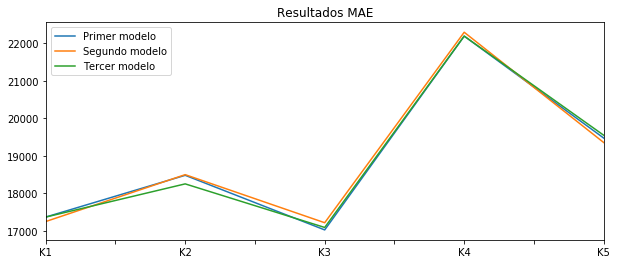

In [683]:
Resultados_MAE.T.plot(title = "Resultados MAE",figsize=(10,4))
plt.show();

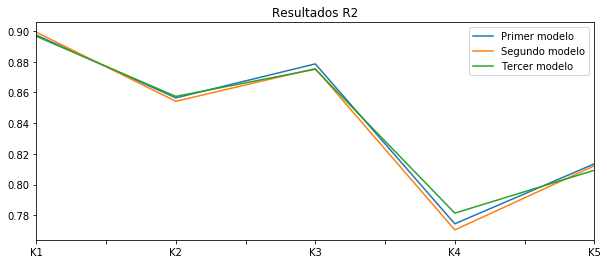

In [684]:
Resultados_R2.T.plot(title = "Resultados R2",figsize=(10,4));

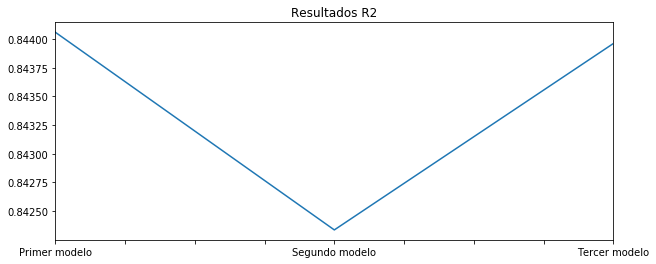

In [675]:
Resultados_R2.T.mean().plot(title = "Resultados R2",figsize=(10,4));

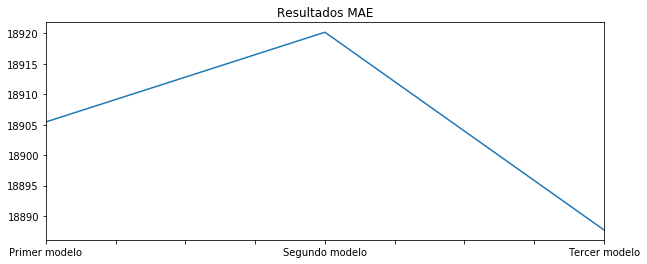

In [676]:
Resultados_MAE.T.mean().plot(title = "Resultados MAE",figsize=(10,4));

<h2 style="color:Darkblue">Resultados:<h2>
    
Mediante el uso del Primer modelo se maximiza el valor promedio de:


$${R}^{2}\;=\; 0.844059517287492\;$$



Mediante el uso del Segundo modelo se minimiza el valor promedio de:



$$MAE\;=\; 18887.72691694639$$